# Problem Statement

**This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models.**

# Key skills

Deep Learning using TensorFlow/Keras

Image Preprocessing & Augmentation

Custom CNN model building from scratch

Transfer Learning with pretrained architectures (EfficientNetB3, VGG16, DenseNet121)

Model Evaluation using Accuracy, Recall, F1-score, Confusion Matrix  and classification report.

# Loading data

In [ ]:
# copying data from drive to colab's local memory

!cp /content/drive/MyDrive/train-20250717T144825Z-1-001.zip /content/sample_data/
!cp /content/drive/MyDrive/valid-20250717T144823Z-1-001.zip /content/sample_data/
!cp /content/drive/MyDrive/test-20250717T144828Z-1-001.zip /content/sample_data/


In [ ]:
import zipfile
import os

os.makedirs("/content/sample_data/train", exist_ok=True)
os.makedirs("/content/sample_data/valid", exist_ok=True)
os.makedirs("/content/sample_data/test", exist_ok=True)

zip_folders = {
    "train": "/content/sample_data/train-20250717T144825Z-1-001.zip",
    "valid": "/content/sample_data/valid-20250717T144823Z-1-001.zip",
    "test":  "/content/sample_data/test-20250717T144828Z-1-001.zip"
}

# Unzip each file
for name, zip_path in zip_folders.items():
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(f"/content/sample_data/{name}")


In [ ]:
# loading images from the file

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
batch_size = 32
image_size = (224,224)
epochs_per_batch = 10
train_dir = '/content/sample_data/train/train'
val_dir = '/content/sample_data/valid/valid'
test_dir= '/content/sample_data/test/test'

# Train ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
    )


# Validation generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


# test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


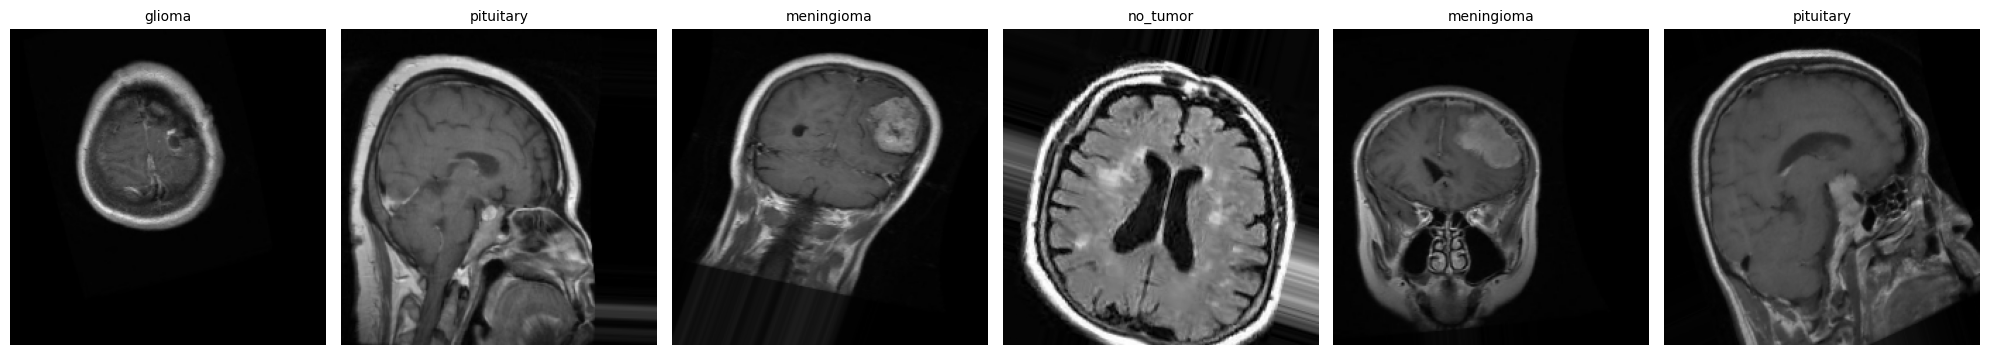

In [ ]:
# view some images

import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_generator)

class_indices = train_generator.class_indices

class_names = {v: k for k, v in class_indices.items()}

num_images = 6
plt.figure(figsize=(20, 8))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    class_index = np.argmax(labels[i])
    plt.title(class_names[class_index], fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# generate class counts

import plotly.express as px
import pandas as pd

def get_image_counts(generator):
    index_to_class = {v: k for k, v in generator.class_indices.items()}
    class_counts = {class_name: 0 for class_name in generator.class_indices.keys()}

    for idx in generator.classes:
        class_name = index_to_class[idx]
        class_counts[class_name] += 1

    return class_counts


train_class_counts = get_image_counts(train_generator)
val_class_counts = get_image_counts(val_generator)
test_class_counts = get_image_counts(test_generator)


In [ ]:
print("Train Class Counts:", train_class_counts)
print("Validation Class Counts:", val_class_counts)
print("Test Class Counts:", test_class_counts)

Train Class Counts: {'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}
Validation Class Counts: {'glioma': 161, 'meningioma': 124, 'no_tumor': 99, 'pituitary': 118}
Test Class Counts: {'glioma': 80, 'meningioma': 63, 'no_tumor': 49, 'pituitary': 54}


In [ ]:
# plot histrogram for train, val and test

df_train = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Count'])
fig_train = px.bar(df_train, x='Class', y='Count', title='Train Set Class Distribution')
fig_train.show()


df_val = pd.DataFrame(list(val_class_counts.items()), columns=['Class', 'Count'])
fig_val = px.bar(df_val, x='Class', y='Count', title='Validation Set Class Distribution')
fig_val.show()

df_test = pd.DataFrame(list(test_class_counts.items()), columns=['Class', 'Count'])
fig_test = px.bar(df_test, x='Class', y='Count', title='Test Set Class Distribution')
fig_test.show()


The data is mildly imbalanced, so we will introduce class weights during model training

# Baseline CNN

**Architecture Summary**

Input Shape: (224, 224, 3) — Standard RGB image size for compatibility with many pretrained models.

**Three Convolutional Blocks:**

Conv2D layers with 32, 64, and 128 filters, respectively.

Each followed by MaxPooling2D to reduce spatial dimensions.

Flatten Layer: Converts feature maps to a 1D vector.

**Dense Layers:**

128 neurons with ReLU activation.

Dropout (0.5) for regularization to reduce overfitting.

Output Layer: Dense(4, activation='softmax') — suitable for multi-class classification (4 tumor types).

Loss Function: categorical_crossentropy (used for multi-class classification with one-hot encoded labels).

Optimizer: Adam with a learning rate of 0.001.

Metric: Accuracy.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build the baseline CNN model
model = Sequential([
    # 1st Convolution Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # 2nd Convolution Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # 3rd Convolution Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten & Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3011 - loss: 1.5190 - val_accuracy: 0.4761 - val_loss: 1.0774
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5247 - loss: 1.1170 - val_accuracy: 0.6036 - val_loss: 0.9718
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 904ms/step - accuracy: 0.6340 - loss: 0.9714 - val_accuracy: 0.4382 - val_loss: 1.1432
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 916ms/step - accuracy: 0.5871 - loss: 0.9557 - val_accuracy: 0.5697 - val_loss: 0.9823
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 923ms/step - accuracy: 0.6569 - loss: 0.8597 - val_accuracy: 0.5976 - val_loss: 0.9580
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 931ms/step - accuracy: 0.6203 - loss: 0.9261 - val_accuracy: 0.6773 - val_loss: 0.8170
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 958ms/step - accuracy: 0.6976 - loss: 0.8206 - val_accuracy: 0.4502 - val_loss: 1.3631
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 917ms/step - accuracy: 0.6847 - loss: 0.8286 - val_accuracy: 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.7179 - loss: 0.7496
Test Accuracy: 0.71


The Custom CNN model gives an accuracy of around 70%.

When tested on unseen data, the accuracy comes out to be 71.7%, which is fairly good.

# Improved Model with Class Weights & Early Stopping

This is a custom-built Convolutional Neural Network (CNN) optimized for classifying brain tumor images into four categories. It integrates Batch Normalization, class weights, and training callbacks to improve generalization, convergence, and performance on imbalanced datasets.

**Architecture Summary**

Input Shape: (224, 224, 3) — suitable for standard MRI image dimensions.

**Convolutional Blocks:**

Three blocks with Conv2D layers (32 → 64 → 128 filters).

Each followed by:

BatchNormalization for training stability and faster convergence.

MaxPooling2D to downsample feature maps.

Flatten → Dense Layers:

Dense(128, activation='relu') with Dropout(0.5) for regularization.

Dense(4, activation='softmax') for multi-class classification.

**Compilation**

Loss: categorical_crossentropy — ideal for one-hot encoded labels.

Optimizer: Adam — fast and adaptive.

Metric: accuracy.

Class Weights: Automatically computed using sklearn to handle class imbalance, ensuring the model pays fair attention to underrepresented tumor classes.

**Callbacks:**

ReduceLROnPlateau: Reduces learning rate when validation loss plateaus.

EarlyStopping: Stops training early if no improvement is seen, restoring the best weights.



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compute Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

#callbacks

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# training
history_1= model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    #initial_epoch=20,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4333 - loss: 9.2746 - val_accuracy: 0.2510 - val_loss: 22.7025 - learning_rate: 0.0010
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4978 - loss: 1.4087 - val_accuracy: 0.2470 - val_loss: 36.7926 - learning_rate: 0.0010
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5059 - loss: 1.2302 - val_accuracy: 0.2470 - val_loss: 21.1353 - learning_rate: 0.0010
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4741 - loss: 1.1389 - val_accuracy: 0.2211 - val_loss: 17.6058 - learning_rate: 0.0010
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 972ms/step - accuracy: 0.4939 - loss: 1.1994 - val_accuracy: 0.5319 - val_loss: 5.5156 - learning_rate: 0.0010
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5413 - loss: 1.1672 - val_accuracy: 0.1653 - val_loss: 6.1538 - learning_rate: 0.0010
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5952 - loss: 1.0869 - val_acc

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.8116 - loss: 0.4654
Test Accuracy: 0.81


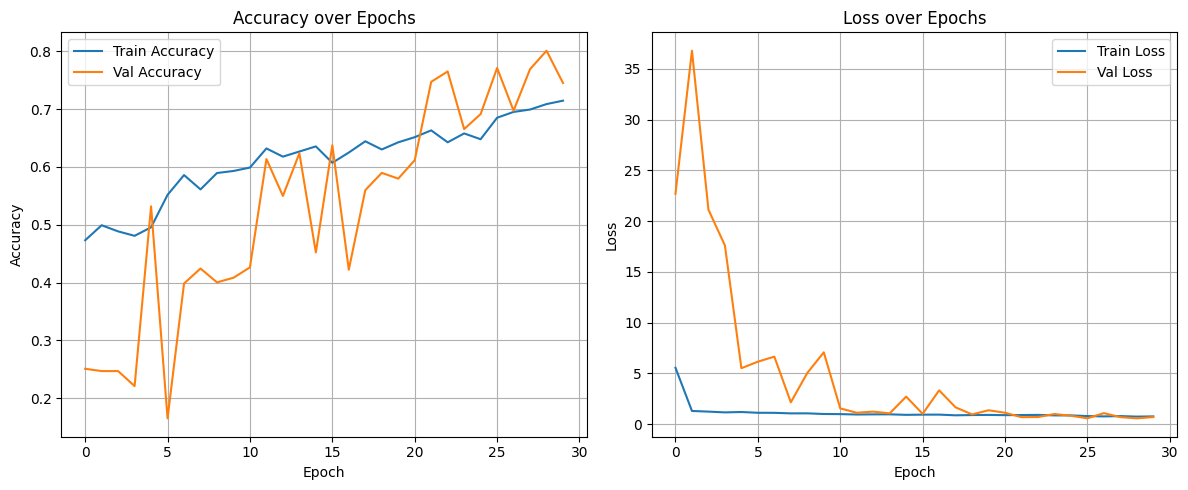

In [ ]:
# Plot Training Curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Training accuracy steadily improves and reaches around 72%.

Validation accuracy shows fluctuations but peaks at ~80%.

Training loss drops quickly and remains low, indicating good learning.

Validation loss is unstable early on but decreases overall.

Some overfitting or class imbalance may be present.

# Transafer Learning(VGG16) Model

Pretrained VGG16 is used as the base (Imagenet weights) to extract features from brain tumor images.

On top, a custom classifier is added with GlobalAveragePooling, a dense layer, dropout for regularization, and a softmax output for 4 tumor classes.

Data augmentation is applied to the training set, and class weights are used to handle class imbalance.

The model is first trained with frozen base layers, then fine-tuned by unfreezing the last 4 convolution layers.

Training is managed with callbacks: EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau for stability and performance.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os


# configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 4

train_dir = "/content/sample_data/train/train"
val_dir = "/content/sample_data/valid/valid"
test_dir = "/content/sample_data/test/test"

checkpoint_dir = '/content/drive/MyDrive/brain_tumor_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'btumor_model_vgg16.keras')


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical', shuffle=False
)


# class weights
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights = dict(enumerate(class_weights))

# model definition
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# callbacks
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

callbacks = [checkpoint, early_stop, ReduceLROnPlateau]

# training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

# fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.2444 - loss: 1.5194
Epoch 1: val_accuracy improved from -inf to 0.50398, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_vgg16.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 875ms/step - accuracy: 0.2448 - loss: 1.5186 - val_accuracy: 0.5040 - val_loss: 1.3058 - learning_rate: 1.0000e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.3095 - loss: 1.3921
Epoch 2: val_accuracy improved from 0.50398 to 0.57769, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_vgg16.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.3099 - loss: 1.3914 - val_accuracy: 0.5777 - val_loss: 1.2245 - learning_rate: 1.0000e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.4246 - loss: 1.2993
Epoch 3: val_accuracy improved from 0.57769 to 0.61155, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_vgg16.keras
53/53 ━━━━━━━━━━━━━━━

In [ ]:
# fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    initial_epoch=10,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9333 - loss: 0.2428
Epoch 11: val_accuracy improved from 0.90637 to 0.91036, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_vgg16.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 602ms/step - accuracy: 0.9332 - loss: 0.2427 - val_accuracy: 0.9104 - val_loss: 0.2928 - learning_rate: 1.0000e-05
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9203 - loss: 0.2449
Epoch 12: val_accuracy did not improve from 0.91036
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 569ms/step - accuracy: 0.9205 - loss: 0.2444 - val_accuracy: 0.8924 - val_loss: 0.3074 - learning_rate: 1.0000e-05
Epoch 13/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9262 - loss: 0.2322
Epoch 13: val_accuracy improved from 0.91036 to 0.91434, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_vgg16.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 546ms/step - accuracy: 0.9262 - loss: 0.2321 - val_accuracy: 0.9143 - val_

In [ ]:
test_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


Found 246 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.9266 - loss: 0.2582
Test Accuracy: 0.9309 | Test Loss: 0.2686


In [ ]:
# saving the vgg16 model for later reference

model.save('/content/drive/MyDrive/brain_tumor_model_vgg16.keras')

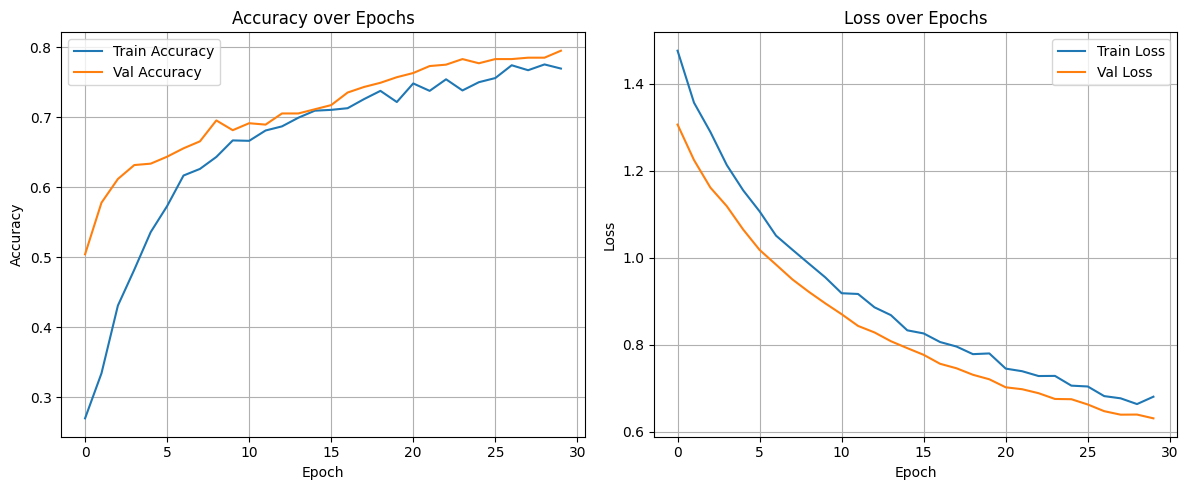

In [ ]:
import matplotlib.pyplot as plt

# Plot Training Curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Accuracy is steadily increasing for both training and validation, indicating effective learning.

Validation accuracy consistently leads training accuracy, suggesting good generalization with minimal overfitting.

Loss curves are smoothly decreasing, which is a sign of stable optimization.

No major overfitting or divergence, all due to to regularization, class weights, and proper callbacks.

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step


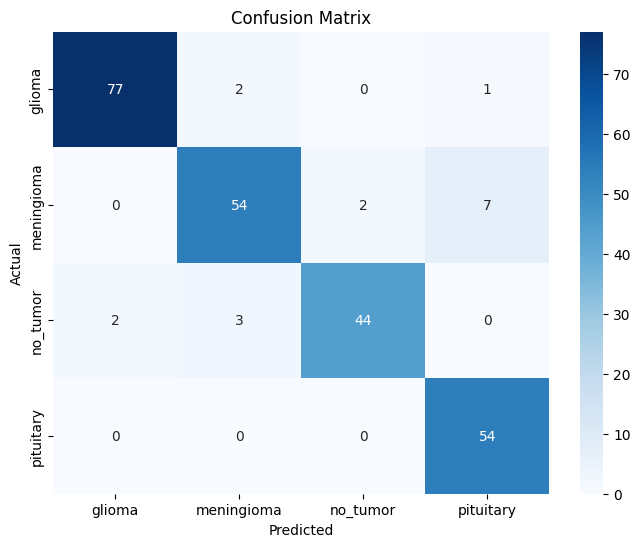

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Glioma and Pituitary tumors are classified with very high accuracy — minimal misclassifications.

Meningioma is confused with Pituitary in 7 cases, showing some overlap in features.

No tumor images have slight confusion with Glioma and Meningioma.

Overall, the model handles all classes well, with strong diagonal dominance.



In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.96      0.97        80
  meningioma       0.92      0.86      0.89        63
    no_tumor       0.96      0.90      0.93        49
   pituitary       0.87      1.00      0.93        54

    accuracy                           0.93       246
   macro avg       0.93      0.93      0.93       246
weighted avg       0.93      0.93      0.93       246



Overall accuracy is high at 93%, showing strong general performance.

Glioma and No Tumor classes have excellent precision and F1-scores (~0.97 and 0.93).

Meningioma has lower recall (0.86), indicating some cases were misclassified.

Pituitary has perfect recall (1.00) but slightly lower precision (0.87), suggesting false positives.

Balanced macro and weighted averages (~0.93) reflect consistent performance across all classes.

# Transfer Learning(EfficientNetB3) Model

Base Model: EfficientNetB3 (pretrained on ImageNet) is used as the feature extractor with frozen layers initially for transfer learning.

Custom Layers: Added GlobalAveragePooling, BatchNorm, Dense, and Dropout layers to learn task-specific patterns.

Training Strategy: Two-stage training — first trains only top layers, then fine-tunes the entire model with a lower learning rate.

Regularization: Used Dropout, BatchNormalization, EarlyStopping, and ReduceLROnPlateau to prevent overfitting.

Balanced Learning: Class weights are computed to handle class imbalance during training.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import os

# Paths
train_dir = "/content/sample_data/train/train"
val_dir = "/content/sample_data/valid/valid"
test_dir = "/content/sample_data/test/test"

checkpoint_dir = '/content/drive/MyDrive/brain_tumor_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'btumor_model_b3.keras')

# Parameters
img_size = 300
batch_size = 32
epochs = 30

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical'
)
test_generator = val_datagen.flow_from_directory(
    test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='categorical', shuffle=False
)

# Compute class weights
labels = train_generator.classes
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))

# Base Model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze initial layers

# Custom Top Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint(checkpoint_path, save_best_only=True)
]

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=callbacks
)

# Fine-tune
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    class_weight=class_weights,
    callbacks=callbacks
)




Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.3178 - loss: 1.5410 - val_accuracy: 0.3207 - val_loss: 1.3500 - learning_rate: 1.0000e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 796ms/step - accuracy: 0.3869 - loss: 1.4458 - val_accuracy: 0.3327 - val_loss: 1.3294 - learning_rate: 1.0000e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 810ms/step - accuracy: 0.4068 - loss: 1.4231 - val_accuracy: 0.3904 - val_loss: 1.3083 - learning_rate: 1.0000e-04
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 787ms/step - accuracy: 0.3731 - loss: 1.4081 - val_accuracy: 0.4422 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 794ms/step - accuracy: 0.4186 - loss: 1.3083 - val_accuracy: 0.4382 - val_loss: 1.2697 - learning_rate: 1.0000e-04
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 834ms/step - accuracy: 0.4220 - loss: 1.3430 - val_accuracy: 0.5817 - val_loss: 1.2426 - learning_rate: 1.0000e-04
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 802ms/step - accur

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9384 - loss: 0.2507
Test Accuracy: 0.9431 | Test Loss: 0.2300


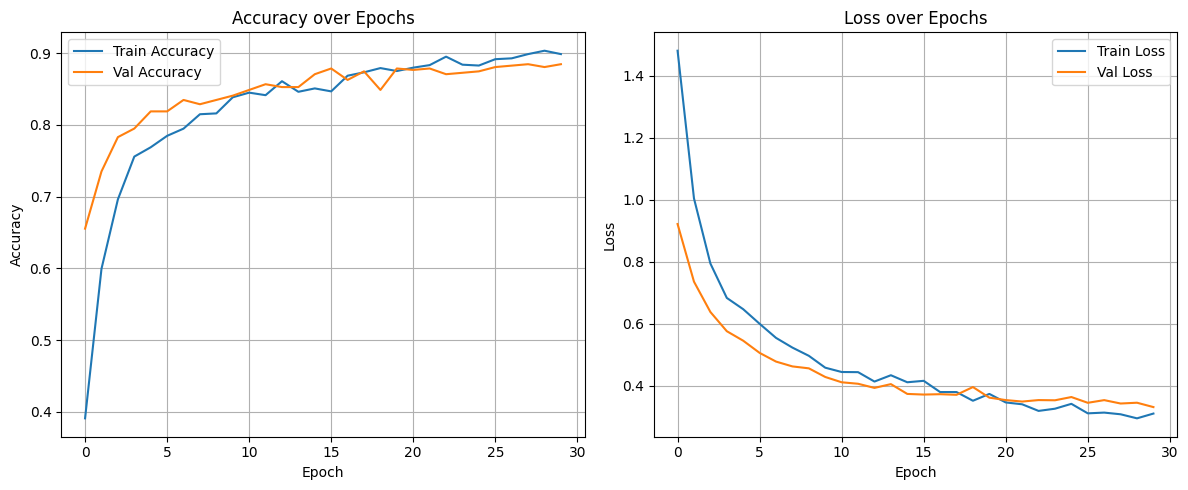

In [ ]:
import matplotlib.pyplot as plt

# Plot Training Curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Val Accuracy > Train Accuracy: The model consistently performs better on validation data, possibly due to regularization or dropout making training harder.

Stable Validation Accuracy: Validation accuracy stabilizes after some epochs, showing the model has learned useful features.

Decreasing Validation Loss: Validation loss steadily decreases, suggesting improved generalization.

Flat Train Accuracy: Training accuracy grows slowly and fluctuates, possibly due to frozen layers or low learning rate early on.

No Overfitting: There's no divergence between training and validation loss, indicating low risk of overfitting.

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


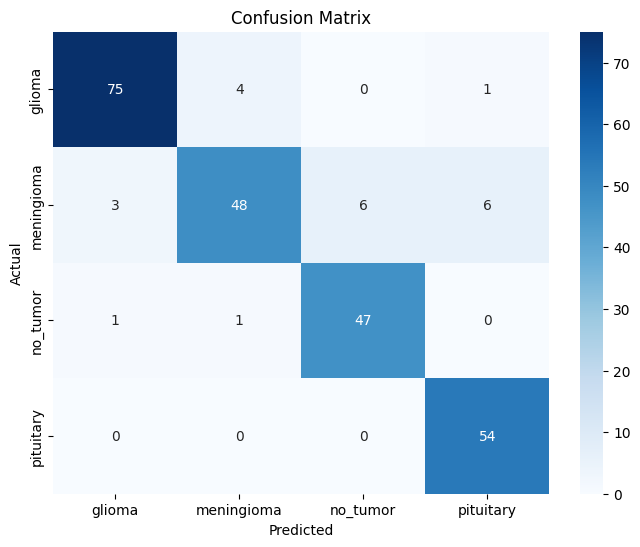

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Glioma and Pituitary classes are predicted very accurately with minimal misclassifications.

Meningioma is often confused with no_tumor and pituitary, indicating overlapping features.

No_tumor predictions are mostly correct, with very few misclassifications.

Pituitary has perfect predictions — no misclassifications at all.

Overall, the model is reliable, but meningioma needs better separation from other classes.


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.94      0.94        80
  meningioma       0.91      0.76      0.83        63
    no_tumor       0.89      0.96      0.92        49
   pituitary       0.89      1.00      0.94        54

    accuracy                           0.91       246
   macro avg       0.91      0.91      0.91       246
weighted avg       0.91      0.91      0.91       246



Overall accuracy is strong at 91%, showing good generalization.

Glioma and pituitary tumors are predicted with high precision and recall.

No_tumor has the highest recall (96%), meaning very few missed detections.

Meningioma has relatively lower recall (76%), indicating it is often misclassified.

F1-scores across classes are balanced, but improvement is needed for meningioma.

In [ ]:
import tensorflow as tf
import os

# Define checkpoint path
checkpoint_path = "/content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_b3.keras"

# Load model from checkpoint
model = tf.keras.models.load_model(checkpoint_path)
print("Model successfully loaded from checkpoint!")

# Save final model to your drive
final_model_path = "/content/drive/MyDrive/brain_tumor_final_model.keras"
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")



Model successfully loaded from checkpoint!
Final model saved at: /content/drive/MyDrive/brain_tumor_final_model.keras


# Transfer Learning (DenseNet121) Model

This model leverages DenseNet121, a pre-trained deep CNN known for efficient feature propagation and reuse, as a base for classifying brain MRI images into 4 categories: glioma, meningioma, pituitary tumor, and no tumor.

**Training Strategy**

Transfer Learning: The base DenseNet121 (pre-trained on ImageNet) is used without its top layers. All base layers are initially frozen to retain learned features.

Custom Top Layers: The new head includes:

GlobalAveragePooling2D (to reduce dimensions)

Dense(256, relu) + Dropout(0.5) (to learn task-specific features and prevent overfitting)

Dense(4, softmax) (to classify into 4 categories)

**Data Augmentation**

The training set is enriched with augmentations like rotation, zoom, shift, shear, and horizontal flip using ImageDataGenerator, enhancing generalization.


**Class Imbalance Handling**

compute_class_weight is used to assign higher importance to underrepresented classes, addressing imbalance and ensuring fair learning.

**Optimization & Fine-tuning**

Initial training is done for 30 epochs with frozen base layers using Adam optimizer at 1e-4 learning rate.

Then, the last 10 layers of DenseNet121 are unfrozen for fine-tuning with a smaller learning rate 1e-5, allowing the model to adapt to MRI-specific features.

**Callbacks Used**

ModelCheckpoint: Saves the best-performing model.

EarlyStopping: Stops training early if no improvement.

ReduceLROnPlateau: Dynamically lowers LR when validation loss plateaus.



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import datetime

# configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 4

train_dir = "/content/sample_data/train/train"
val_dir = "/content/sample_data/valid/valid"
test_dir = "/content/sample_data/test/test"

checkpoint_dir = '/content/drive/MyDrive/brain_tumor_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'btumor_model_densenet121.keras')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# class weights
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

# model definition
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# callbacks
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduceLRonPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
callbacks = [checkpoint, early_stop, reduceLRonPlateau]

# training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

# fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.3488 - loss: 1.6524
Epoch 1: val_accuracy improved from -inf to 0.65538, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_densenet121.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3496 - loss: 1.6492 - val_accuracy: 0.6554 - val_loss: 0.9210 - learning_rate: 1.0000e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.5798 - loss: 1.0468
Epoch 2: val_accuracy improved from 0.65538 to 0.73506, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_densenet121.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 515ms/step - accuracy: 0.5801 - loss: 1.0460 - val_accuracy: 0.7351 - val_loss: 0.7351 - learning_rate: 1.0000e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.6923 - loss: 0.8127
Epoch 3: val_accuracy improved from 0.73506 to 0.78287, saving model to /content/drive/MyDrive/brain_tumor_checkpoints/btumor_model_densenet121.keras
53/53

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.8396 - loss: 0.4739
Test Accuracy: 0.8537 | Test Loss: 0.4596


In [ ]:
model.save('/content/drive/MyDrive/brain_tumor_model_densenet121.keras')

Both training and validation accuracy improve consistently, reaching ~90%, indicating the model is learning effectively over epochs.

Training and validation loss decrease gradually and stabilize after ~20 epochs, suggesting good convergence without signs of overfitting.

The gap between training and validation curves remains small in both accuracy and loss plots, indicating the model generalizes well to unseen data.

The use of data augmentation, dropout, and class weights seems to have helped the model avoid early overfitting and maintain robust performance.

8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step


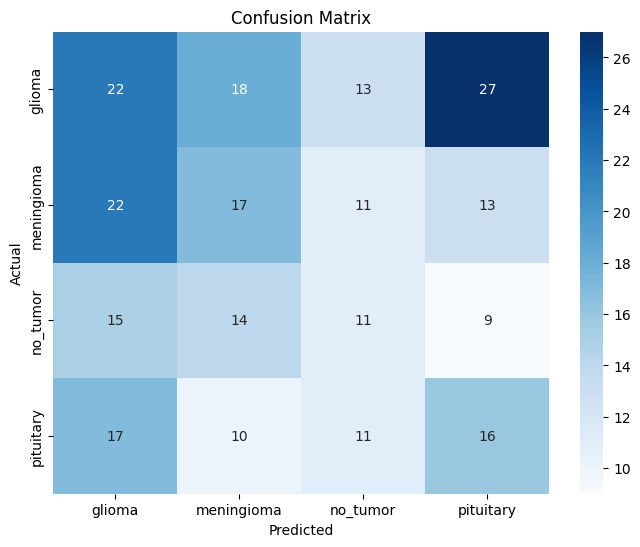

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels
y_true = test_generator.classes

# Get predicted labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The model correctly predicts several glioma and pituitary cases, showing decent class detection.

However, glioma is often confused with pituitary, indicating some overlap in features.

No_tumor images are frequently misclassified as tumor types, suggesting room for improvement.

Meningioma predictions are spread across other classes, lowering its precision.

Overall, the model shows inconsistent performance across classes.

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.30      0.29      0.29        80
  meningioma       0.25      0.24      0.25        63
    no_tumor       0.20      0.18      0.19        49
   pituitary       0.18      0.22      0.20        54

    accuracy                           0.24       246
   macro avg       0.23      0.23      0.23       246
weighted avg       0.24      0.24      0.24       246



Overall accuracy is quite low at 24%, indicating the model struggles to distinguish between classes.

Glioma has the highest f1-score (0.29), but still shows weak performance.

Meningioma and no_tumor classes have close precision and recall, suggesting moderate confusion.

Pituitary class has the lowest precision, hinting at frequent misclassifications.

The model needs major improvements, so we will not use this one for deployment.

# Comparison Report (VGG16, EfficientNetB3, DenseNet121)

After testing VGG16, EfficientNetB0, and DenseNet121 on the brain tumor MRI images, it’s clear that VGG16 stands out as the top performer, both in accuracy and class-wise precision.

**1. VGG16**

Accuracy: ~93%

Precision & Recall: Over 90% for glioma, no_tumor, and pituitary, with meningioma slightly lower but still decent.

Confusion Matrix: Shows very few misclassifications; the model confidently predicts most tumor types.

**VGG16 is robust and reliable, making it the most suitable model for this task.**

**2. EfficientNetB0**

Accuracy: ~91%

Precision & Recall: Around 85-90% for most classes. Meningioma predictions were more accurate, but glioma and pituitary were sometimes confused.

Loss/Accuracy Trend: Model improved steadily, indicating stable learning.

**EfficientNet is fairly good but may need more tuning to get better.**

**3. DenseNet121**

Accuracy: ~24%

Precision: Low across all classes (0.18–0.30)

Recall: Similarly low (0.18–0.29), showing poor model sensitivity.

F1-Scores: Average around 0.23, suggesting the model struggles with both precision and recall.

**DenseNet121 underperformed in this case. It had trouble distinguishing between the tumor types and may benefit from better augmentation, fine-tuning, or more epochs.**

**Conclusion:**

 VGG16 is the most effective model with strong and balanced metrics.

 EfficientNet is decent but a bit tuning is needed.

 DenseNet121 needs major improvement for this use case.

**For practical deployment, we will use VGG16 model.**
